## The Exercise

Your goal is to build and train a neural network that performs single object localization using the Keras framework and the Oxford Pets dataset. You can leverage much of the code from the Object Localization Jupyter notebook, and you'll have to add and modify some code as well.

### Part 1: Download the data

You can download the images and annotations for the Oxford Pets dataset from this website [https://www.robots.ox.ac.uk/~vgg/data/pets/](https://www.robots.ox.ac.uk/~vgg/data/pets/). The downloads section is near the top of the page. You will need to download both the "images" and "ground truth" datasets for this exercise.

### Part 2: Parse and prepare the data

The dataset is described extensively on the website, as well as the Object Localization notebook in this same folder. Additionally, the notebook contains Python code that parses the raw data into a format that is ready for Keras to process. For each image you should:

1. Extract the image data and turn it into a Numpy array.
1. Ensure the image is square by padding it appropriately with black pixels.
1. Scale the image to an appropriate size as determined by the neural network you import (e.g. Xception, MobileNetV2, etc.)
1. Extract the bounding box from the XML file associated with each image.
1. Appropriately adjust the bounding box for any padding and resizing that the image received.
1. Extract the classification labels for each image.
1. Ignore images that do not have a bounding box in the provided annotations.

The provided notebook has code that performs all of these steps, you may wish to use it here.

### Part 3: Import and prepare a CNN

Like in previous labs and exercises, we're applying transfer learning. Import a pre-trained network from Keras with `include_top=False`. Then, using the Keras functional API, give that network two prediction heads: one for classification and one for object localization.

You'll have to decide which loss functions to use, and how to weight the predictions from each head during training at this point as well. In the notebook we used `binary_crossentropy` for the classifier, and `mse` for the localizer with weights of `1` and `800` respectively (those weights were chosen arbitrarily, but worked decently). You may wish to experiment with other options.

**Challenge Opportunity** in the provided notebook, we only classify images as being of a "dog" or "cat" but the provided dataset has more detailed labels for the breed of each dog or cat. You can choose to implement a simpler "dog or cat" classifier, as done in the provided notebook, or make your network predict the breed. If you go for breed then your classification head will need a node for each possible breed, which means you will also not want to use `binary_crossentropy` as your loss function, since it is designed for binary classifiers.

**Challenge Opportunity** in the provided notebook we have our network predict the pixel position of the bounding box. Better performance can often be achieved by normalizing these values between 0-1. In other words, for each of the four points in our bounding box, have your model predict those positions as a scalar relative to the image size, rather than absolute pixel position. Normalizing these outputs will require you to change the way we process the image and XML input data.

**Challenge Opportunity** Accuracy is one popular metric for judging the performance of a classifier. [Intersection over Union](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) is a popular metric for judging the accuracy of an object localization model. Consider implementing a custom metric to compute the intersection over union as a validation metric for your model, and plot its change over time during training alongside accuracy and the `mse` loss.

### Part 4: Train and evaluate the model

Training the model may take a long time, particularly if you'd like to do several epochs. Once you've trained the network evaluate its performance by looking at the loss and accuracy metrics, as well as looking at several of your networks predictions. Code for visualizing the networks predicted bounding boxes and the ground truth from in the dataset is provided in the Object Localization Jupyter notebook.

### Part 2: Parse and prepare the data

The dataset is described extensively on the website, as well as the Object Localization notebook in this same folder. Additionally, the notebook contains Python code that parses the raw data into a format that is ready for Keras to process. For each image you should:

1. Extract the image data and turn it into a Numpy array.
2. Ensure the image is square by padding it appropriately with black pixels.
3. Scale the image to an appropriate size as determined by the neural network you import (e.g. Xception, MobileNetV2, etc.)
4. Extract the bounding box from the XML file associated with each image.
5. Appropriately adjust the bounding box for any padding and resizing that the image received.
6. Extract the classification labels for each image.
7. Ignore images that do not have a bounding box in the provided annotations.

The provided notebook has code that performs all of these steps, you may wish to use it here.


In [2]:

# All the imports:
from collections import namedtuple
import csv

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image, ImageOps

# This is new, the XML parsing library comes with Python
import xml.etree.ElementTree as ET

In [3]:
# First, we have to download and prepare the data. We're using the Oxford Pet dataset
# linked above. You need the "dataset" and the "groundtruth data" listed under Downloads

# Modify these to fit wherever you save the data.
PATH_TO_IMAGES = './OxfordPets/images/'
PATH_TO_CLASS_LIST = './OxfordPets/annotations/list.txt'
PATH_TO_XML_ANNOTATIONS = './OxfordPets/annotations/xmls'

# Change if you wish. 
TARGET_SIZE = (224, 224)

In [4]:


# Just to make the code a bit easier to read.
BoundingBox = namedtuple('BoundingBox', 'xmin ymin xmax ymax')

# A function to read the XML and return (xmin, ymin, xmax, ymax)
def get_bounding_box(path_to_xml_annotation):
    tree = ET.parse(path_to_xml_annotation)
    root = tree.getroot()
    
    path_to_box = './object/bndbox/'
    xmin = int(root.find(path_to_box + "xmin").text)
    ymin = int(root.find(path_to_box + "ymin").text)
    xmax = int(root.find(path_to_box + "xmax").text)
    ymax = int(root.find(path_to_box + "ymax").text)

    return BoundingBox(xmin, ymin, xmax, ymax)

In [5]:
# A function to reshape the images and appropriately transform
# the bounding box for that image. Much of this comes from last lab
# and should look familiar.
def resize_image_with_bounds(path_to_image, bounding_box=None, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    # When we pad the image to square, we have to adjust all the bounding box
    # values by the amounts we added on the left or top. The "bonus" pads are
    # always done on the bottom and right so we can ignore them in terms of the box.
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    
    if bounding_box is not None:
        new_xmin = bounding_box.xmin + w_pad
        new_xmax = bounding_box.xmax + w_pad
        new_ymin = bounding_box.ymin + h_pad
        new_ymax = bounding_box.ymax + h_pad
    
    # When we resize the image, it's by some scalar. We have to apply that 
    # scalar to the bounding box as well. We may lose a small amount of precision
    # when we do this, but not so much that it'll hurt our predictions
    if target_size is not None:
        # Note, width and height have changed due to the padding resize.
        # Update our notions so we get the scale factor right
        width, height = image.size

        image = image.resize(target_size)
        
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height

        if bounding_box is not None:
            new_xmin = new_xmin * width_scale
            new_xmax = new_xmax * width_scale
            new_ymin = new_ymin * height_scale
            new_ymax = new_ymax * height_scale
    
    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    
    # Image data is a 3D array, 3 channels (RGB) of target_size.
    # RBG values are from 0-255. Later in this notebook we preprocess
    # those images with the MobileNetV2 preprocess input function. 
    if bounding_box is None:
        return image_data, None
    
    return (image_data, BoundingBox(new_xmin, new_ymin, new_xmax, new_ymax))

In [6]:
# Given the relevant data from a row of the CSV return a reshaped image
# as well as it's transformed bounding box
def prepare_sample_from_name(sample_name):
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    path_to_xml = os.path.join(PATH_TO_XML_ANNOTATIONS, sample_name + '.xml')

    original_bounding_box = get_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_with_bounds(path_to_image, original_bounding_box, TARGET_SIZE)
    
    return (image_data, bounding_box)

In [7]:
# Given the image data, plot the data with the bounding box.
# for testing/verification purposes. 
def plot_with_box(image_data, bounding_box, compare_box=None):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_data)

    # Create a Rectangle patch. 
    rect_red = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
                             bounding_box.xmax - bounding_box.xmin,
                             bounding_box.ymax - bounding_box.ymin,
                             linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect_red)

    if compare_box is not None:
        rect_blue = patches.Rectangle((compare_box.xmin, compare_box.ymin),
                             compare_box.xmax - compare_box.xmin,
                             compare_box.ymax - compare_box.ymin,
                             linewidth=2, edgecolor='b', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_blue)

    plt.show()

In [119]:
# Okay, lets get all our samples processed. After this we'll prepare the 
# data and labels for our network and perform a validation split.
processed_data = [] #PROCESSES DATA INTO A TUPLE: processed_data = np.array(processed_data)

# Processing all this data takes some time... 
# Took my laptop roughly 5 minutes
with open(PATH_TO_CLASS_LIST) as csv_list_file: #PATH_TO_CLASS_LIST = './OxfordPets/annotations/list.txt'
    
#Image CLASS-ID SPECIES BREED ID - This is what the file looks like inside
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog
#All images with 1st letter as captial are cat images
#images with small first letter are dog images
    
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    
    for row in csv_reader:
        if row[0].startswith('#'): continue
        
        # Unpack for readability
        sample_name, class_id, species, breed_id = row

        # Not every image has a bounding box, some files are missing.
        # Use a try/except block to ignore such samples
        try:
            image, bounding_box = prepare_sample_from_name(sample_name) #returns(image_data, bounding_box) from XMLfiles
        except FileNotFoundError:
            # This actually happens quite a lot, as you can see in the output.
            # we end up with 7349 samples.
            print(f'No annotations for {sample_name}: skipped.')
            continue
        
        # species - 1 so cat = 0 and dog = 1.
        # Makes things a little easier to process
        data_tuple = (image, int(class_id) - 1, bounding_box)
        processed_data.append(data_tuple)
        
print(f'Processed {len(processed_data)} samples')

# Make it a numpy array
processed_data = np.array(processed_data) 

No annotations for Abyssinian_104: skipped.
No annotations for Bengal_111: skipped.
No annotations for samoyed_10: skipped.
No annotations for Bengal_175: skipped.
No annotations for Egyptian_Mau_14: skipped.
No annotations for Egyptian_Mau_156: skipped.
No annotations for Egyptian_Mau_186: skipped.
No annotations for Ragdoll_199: skipped.
No annotations for saint_bernard_15: skipped.
No annotations for Abyssinian_201: skipped.
No annotations for Abyssinian_202: skipped.
No annotations for Abyssinian_204: skipped.
No annotations for Abyssinian_205: skipped.
No annotations for Abyssinian_206: skipped.
No annotations for Abyssinian_207: skipped.
No annotations for Abyssinian_20: skipped.
No annotations for Abyssinian_210: skipped.
No annotations for Abyssinian_212: skipped.
No annotations for Abyssinian_213: skipped.
No annotations for Abyssinian_215: skipped.
No annotations for Abyssinian_216: skipped.
No annotations for Abyssinian_217: skipped.
No annotations for Abyssinian_219: skippe

No annotations for american_pit_bull_terrier_51: skipped.
No annotations for american_pit_bull_terrier_52: skipped.
No annotations for american_pit_bull_terrier_53: skipped.
No annotations for american_pit_bull_terrier_54: skipped.
No annotations for american_pit_bull_terrier_55: skipped.
No annotations for american_pit_bull_terrier_56: skipped.
No annotations for american_pit_bull_terrier_57: skipped.
No annotations for american_pit_bull_terrier_58: skipped.
No annotations for american_pit_bull_terrier_59: skipped.
No annotations for american_pit_bull_terrier_5: skipped.
No annotations for american_pit_bull_terrier_60: skipped.
No annotations for american_pit_bull_terrier_61: skipped.
No annotations for american_pit_bull_terrier_62: skipped.
No annotations for american_pit_bull_terrier_63: skipped.
No annotations for american_pit_bull_terrier_64: skipped.
No annotations for american_pit_bull_terrier_65: skipped.
No annotations for american_pit_bull_terrier_66: skipped.
No annotations 

No annotations for Bengal_1: skipped.
No annotations for Bengal_200: skipped.
No annotations for Bengal_201: skipped.
No annotations for Bengal_20: skipped.
No annotations for Bengal_21: skipped.
No annotations for Bengal_22: skipped.
No annotations for Bengal_23: skipped.
No annotations for Bengal_24: skipped.
No annotations for Bengal_25: skipped.
No annotations for Bengal_26: skipped.
No annotations for Bengal_27: skipped.
No annotations for Bengal_28: skipped.
No annotations for Bengal_29: skipped.
No annotations for Bengal_2: skipped.
No annotations for Bengal_30: skipped.
No annotations for Bengal_31: skipped.
No annotations for Bengal_32: skipped.
No annotations for Bengal_33: skipped.
No annotations for Bengal_34: skipped.
No annotations for Bengal_35: skipped.
No annotations for Bengal_36: skipped.
No annotations for Bengal_37: skipped.
No annotations for Bengal_38: skipped.
No annotations for Bengal_39: skipped.
No annotations for Bengal_3: skipped.
No annotations for Bengal_

No annotations for boxer_55: skipped.
No annotations for boxer_56: skipped.
No annotations for boxer_57: skipped.
No annotations for boxer_58: skipped.
No annotations for boxer_59: skipped.
No annotations for boxer_5: skipped.
No annotations for boxer_60: skipped.
No annotations for boxer_61: skipped.
No annotations for boxer_62: skipped.
No annotations for boxer_63: skipped.
No annotations for boxer_64: skipped.
No annotations for boxer_65: skipped.
No annotations for boxer_66: skipped.
No annotations for boxer_67: skipped.
No annotations for boxer_68: skipped.
No annotations for boxer_69: skipped.
No annotations for boxer_6: skipped.
No annotations for boxer_70: skipped.
No annotations for boxer_71: skipped.
No annotations for boxer_72: skipped.
No annotations for boxer_73: skipped.
No annotations for boxer_74: skipped.
No annotations for boxer_75: skipped.
No annotations for boxer_76: skipped.
No annotations for boxer_77: skipped.
No annotations for boxer_78: skipped.
No annotations

No annotations for english_cocker_spaniel_47: skipped.
No annotations for english_cocker_spaniel_48: skipped.
No annotations for english_cocker_spaniel_49: skipped.
No annotations for english_cocker_spaniel_4: skipped.
No annotations for english_cocker_spaniel_50: skipped.
No annotations for english_cocker_spaniel_51: skipped.
No annotations for english_cocker_spaniel_52: skipped.
No annotations for english_cocker_spaniel_53: skipped.
No annotations for english_cocker_spaniel_54: skipped.
No annotations for english_cocker_spaniel_55: skipped.
No annotations for english_cocker_spaniel_56: skipped.
No annotations for english_cocker_spaniel_57: skipped.
No annotations for english_cocker_spaniel_58: skipped.
No annotations for english_cocker_spaniel_59: skipped.
No annotations for english_cocker_spaniel_5: skipped.
No annotations for english_cocker_spaniel_60: skipped.
No annotations for english_cocker_spaniel_61: skipped.
No annotations for english_cocker_spaniel_62: skipped.
No annotatio

No annotations for great_pyrenees_79: skipped.
No annotations for great_pyrenees_7: skipped.
No annotations for great_pyrenees_80: skipped.
No annotations for great_pyrenees_81: skipped.
No annotations for great_pyrenees_82: skipped.
No annotations for great_pyrenees_83: skipped.
No annotations for great_pyrenees_84: skipped.
No annotations for great_pyrenees_85: skipped.
No annotations for great_pyrenees_86: skipped.
No annotations for great_pyrenees_87: skipped.
No annotations for great_pyrenees_88: skipped.
No annotations for great_pyrenees_89: skipped.
No annotations for great_pyrenees_8: skipped.
No annotations for great_pyrenees_90: skipped.
No annotations for great_pyrenees_91: skipped.
No annotations for great_pyrenees_92: skipped.
No annotations for great_pyrenees_93: skipped.
No annotations for great_pyrenees_94: skipped.
No annotations for great_pyrenees_95: skipped.
No annotations for great_pyrenees_96: skipped.
No annotations for great_pyrenees_97: skipped.
No annotations 

No annotations for Maine_Coon_254: skipped.
No annotations for Maine_Coon_25: skipped.
No annotations for Maine_Coon_262: skipped.
No annotations for Maine_Coon_263: skipped.
No annotations for Maine_Coon_264: skipped.
No annotations for Maine_Coon_265: skipped.
No annotations for Maine_Coon_266: skipped.
No annotations for Maine_Coon_267: skipped.
No annotations for Maine_Coon_268: skipped.
No annotations for Maine_Coon_269: skipped.
No annotations for Maine_Coon_26: skipped.
No annotations for Maine_Coon_270: skipped.
No annotations for Maine_Coon_271: skipped.
No annotations for Maine_Coon_272: skipped.
No annotations for Maine_Coon_27: skipped.
No annotations for Maine_Coon_28: skipped.
No annotations for Maine_Coon_29: skipped.
No annotations for Maine_Coon_2: skipped.
No annotations for Maine_Coon_30: skipped.
No annotations for Maine_Coon_31: skipped.
No annotations for Maine_Coon_32: skipped.
No annotations for Maine_Coon_33: skipped.
No annotations for Maine_Coon_34: skipped.


No annotations for newfoundland_95: skipped.
No annotations for newfoundland_96: skipped.
No annotations for newfoundland_97: skipped.
No annotations for newfoundland_98: skipped.
No annotations for newfoundland_99: skipped.
No annotations for newfoundland_9: skipped.
No annotations for Persian_21: skipped.
No annotations for Persian_221: skipped.
No annotations for Persian_224: skipped.
No annotations for Persian_228: skipped.
No annotations for Persian_22: skipped.
No annotations for Persian_233: skipped.
No annotations for Persian_239: skipped.
No annotations for Persian_255: skipped.
No annotations for Persian_256: skipped.
No annotations for Persian_257: skipped.
No annotations for Persian_258: skipped.
No annotations for Persian_259: skipped.
No annotations for Persian_25: skipped.
No annotations for Persian_260: skipped.
No annotations for Persian_261: skipped.
No annotations for Persian_262: skipped.
No annotations for Persian_263: skipped.
No annotations for Persian_264: skipp

No annotations for Ragdoll_2: skipped.
No annotations for Ragdoll_30: skipped.
No annotations for Ragdoll_31: skipped.
No annotations for Ragdoll_32: skipped.
No annotations for Ragdoll_33: skipped.
No annotations for Ragdoll_34: skipped.
No annotations for Ragdoll_35: skipped.
No annotations for Ragdoll_36: skipped.
No annotations for Ragdoll_37: skipped.
No annotations for Ragdoll_3: skipped.
No annotations for Ragdoll_40: skipped.
No annotations for Ragdoll_41: skipped.
No annotations for Ragdoll_42: skipped.
No annotations for Ragdoll_43: skipped.
No annotations for Ragdoll_44: skipped.
No annotations for Ragdoll_45: skipped.
No annotations for Ragdoll_47: skipped.
No annotations for Ragdoll_48: skipped.
No annotations for Ragdoll_49: skipped.
No annotations for Ragdoll_4: skipped.
No annotations for Ragdoll_51: skipped.
No annotations for Ragdoll_52: skipped.
No annotations for Ragdoll_53: skipped.
No annotations for Ragdoll_54: skipped.
No annotations for Ragdoll_56: skipped.
No 

No annotations for samoyed_198: skipped.
No annotations for samoyed_199: skipped.
No annotations for samoyed_19: skipped.
No annotations for samoyed_1: skipped.
No annotations for samoyed_200: skipped.
No annotations for samoyed_202: skipped.
No annotations for samoyed_20: skipped.
No annotations for samoyed_21: skipped.
No annotations for samoyed_22: skipped.
No annotations for samoyed_23: skipped.
No annotations for samoyed_24: skipped.
No annotations for samoyed_25: skipped.
No annotations for samoyed_26: skipped.
No annotations for samoyed_27: skipped.
No annotations for samoyed_28: skipped.
No annotations for samoyed_29: skipped.
No annotations for samoyed_2: skipped.
No annotations for samoyed_30: skipped.
No annotations for samoyed_31: skipped.
No annotations for samoyed_32: skipped.
No annotations for samoyed_33: skipped.
No annotations for samoyed_34: skipped.
No annotations for samoyed_35: skipped.
No annotations for samoyed_36: skipped.
No annotations for samoyed_37: skipped

No annotations for shiba_inu_75: skipped.
No annotations for shiba_inu_76: skipped.
No annotations for shiba_inu_77: skipped.
No annotations for shiba_inu_78: skipped.
No annotations for shiba_inu_79: skipped.
No annotations for shiba_inu_7: skipped.
No annotations for shiba_inu_80: skipped.
No annotations for shiba_inu_81: skipped.
No annotations for shiba_inu_82: skipped.
No annotations for shiba_inu_83: skipped.
No annotations for shiba_inu_84: skipped.
No annotations for shiba_inu_85: skipped.
No annotations for shiba_inu_86: skipped.
No annotations for shiba_inu_87: skipped.
No annotations for shiba_inu_88: skipped.
No annotations for shiba_inu_89: skipped.
No annotations for shiba_inu_8: skipped.
No annotations for shiba_inu_90: skipped.
No annotations for shiba_inu_91: skipped.
No annotations for shiba_inu_92: skipped.
No annotations for shiba_inu_93: skipped.
No annotations for shiba_inu_94: skipped.
No annotations for shiba_inu_95: skipped.
No annotations for shiba_inu_96: ski

No annotations for wheaten_terrier_72: skipped.
No annotations for wheaten_terrier_73: skipped.
No annotations for wheaten_terrier_74: skipped.
No annotations for wheaten_terrier_75: skipped.
No annotations for wheaten_terrier_76: skipped.
No annotations for wheaten_terrier_77: skipped.
No annotations for wheaten_terrier_78: skipped.
No annotations for wheaten_terrier_79: skipped.
No annotations for wheaten_terrier_7: skipped.
No annotations for wheaten_terrier_80: skipped.
No annotations for wheaten_terrier_81: skipped.
No annotations for wheaten_terrier_82: skipped.
No annotations for wheaten_terrier_83: skipped.
No annotations for wheaten_terrier_84: skipped.
No annotations for wheaten_terrier_85: skipped.
No annotations for wheaten_terrier_86: skipped.
No annotations for wheaten_terrier_87: skipped.
No annotations for wheaten_terrier_88: skipped.
No annotations for wheaten_terrier_89: skipped.
No annotations for wheaten_terrier_8: skipped.
No annotations for wheaten_terrier_90: ski

What is the difference between a training set and a validation set?

The training set is used to learn the system's parameters, e.g. feature weights. 
- A systems parameters would be Age, Location
- The weights would be the trajectory caused by those parameters

The validation set is a held-out dataset used to tune the system's hyper-parameters, e.g. number of EM iterations, number of hidden units, etc. 
- In other words; data that will fine-tune the correct 'training data'. 

You set various different values to the hyper-parameters, train the system using the training set, and choose the hyper-parameters' values that yield the best performance on the validation set.

Eventually, once you have a trained model, you test it on another separate dataset, the test set, to evaluate the model's performance on unseen data.
------d

Invoked preprocessed data

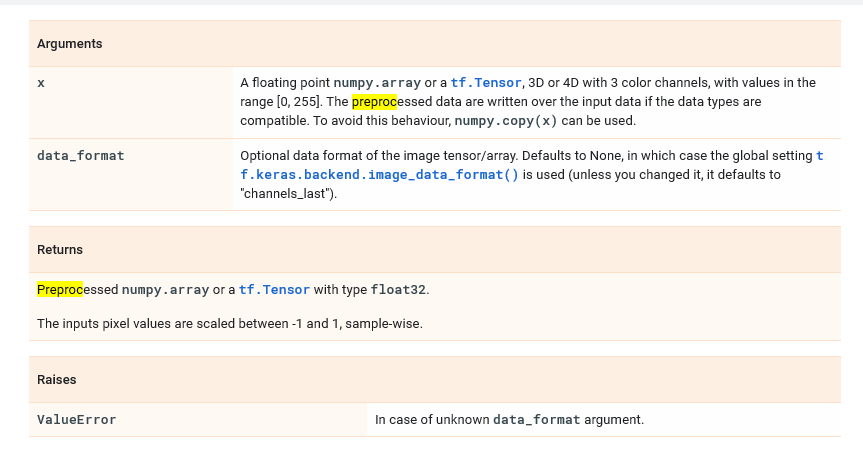

In [122]:
# We still have to split our data. We also have to create TWO separate 
# label groups, since we're going to handle the classificaton and 
# bounding box predictions separately. 
x_train = []
y_class_train = []
y_box_train = []

x_validation = []
y_class_validation = []
y_box_validation = []

validation_split = 0.2 #Why this? 20% is Validation pile - the other Training Pile

# Notice that we're applying the preprocess_input function here:
for image, class_id, bounding_box in processed_data:
    if np.random.random() > validation_split:
        x_train.append(preprocess_input(image))
        y_class_train.append(class_id)
        y_box_train.append(bounding_box)
    else:
        x_validation.append(preprocess_input(image))
        y_class_validation.append(class_id)
        y_box_validation.append(bounding_box)
        
x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)

print("y_class_train"+str(y_class_train))
y_categorized_train = to_categorical(y_class_train, 37)
print("y_class_train"+str(y_categorized_train))

x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)

print("y_class_validation"+str(y_class_validation))
y_categorized_valid =to_categorical(y_class_validation, 37)
print("y_class_validation"+str(y_categorized_valid))

y_class_train[ 0  0  0 ... 36 36 36]
y_class_train[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
y_class_validation[ 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2
  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 12 12 12 12 12 12
 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21
 21 21 21 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 24 24
 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 

In [46]:
#--

### Part 3: Import and prepare a CNN

Like in previous labs and exercises, we're applying transfer learning. Import a pre-trained network from Keras with `include_top=False`. Then, using the Keras functional API, give that network two prediction heads: one for classification and one for object localization.

You'll have to decide which loss functions to use, and how to weight the predictions from each head during training at this point as well. In the notebook we used `binary_crossentropy` for the classifier, and `mse` for the localizer with weights of `1` and `800` respectively (those weights were chosen arbitrarily, but worked decently). You may wish to experiment with other options.

**Challenge Opportunity** in the provided notebook, we only classify images as being of a "dog" or "cat" but the provided dataset has more detailed labels for the breed of each dog or cat. You can choose to implement a simpler "dog or cat" classifier, as done in the provided notebook, or make your network predict the breed. If you go for breed then your classification head will need a node for each possible breed, which means you will also not want to use `binary_crossentropy` as your loss function, since it is designed for binary classifiers.

They invoke #Imagenet#: MobileNet-v2 is a convolutional neural network that is 53 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database [1]. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224. 

**Challenge Opportunity** in the provided notebook we have our network predict the pixel position of the bounding box. Better performance can often be achieved by normalizing these values between 0-1. In other words, for each of the four points in our bounding box, have your model predict those positions as a scalar relative to the image size, rather than absolute pixel position. Normalizing these outputs will require you to change the way we process the image and XML input data.

**Challenge Opportunity** Accuracy is one popular metric for judging the performance of a classifier. [Intersection over Union](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) is a popular metric for judging the accuracy of an object localization model. Consider implementing a custom metric to compute the intersection over union as a validation metric for your model, and plot its change over time during training alongside accuracy and the `mse` loss.

In [127]:
# We don't have a TON of data. It's also much harder to use image augmentation
# since we'd have to apply the transformation to the bounding box data as well
# Lets still use transfer learning
# Like before, we grab a pretrained model with include_top=False
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)) #TARGET_SIZE = (224, 224)

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output]) #why did we chop?

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=37, activation='softmax')(classification_output)
    

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________________________

In [128]:
# okay, now when we compile the model we have to provide it with two loss functions
# one for each output layer.

model.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[800, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
) 

print("x_train: "+str(x_train)+"\n\n")
print("[y_class_train, y_box_train]: "+str([y_class_train, y_box_train])+"\n\n")
print("x_validation"+str(x_validation)+"\n\n")
print("\[y_class_validation, y_box_validation\]"+str([y_class_validation, y_box_validation])+"\n\n")

#categorized_y = to_categorical(y_class_validation, 32)

#print("\[categorized_y, y_box_validation\]"+str([categorized_y, y_box_validation])+"\n\n")

model.fit(x_train, #Contains a bunch of -1 - why? These are pixel values post preprocess-input()
[y_class_train, y_box_train], #Species and bounding box 
validation_data=(x_validation, [y_categorized_valid, y_box_validation]), # x_val (Preprocessed -1,0) - [Species, BoxValue]
epochs=3,
verbose=True
)

x_train: [[[[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  ...

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]]


 [[[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
  

ValueError: You are passing a target array of shape (2951, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

Category7.410202e-07
TestPseudo12
5


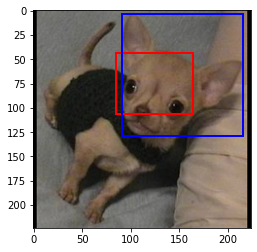

Category1.158487e-08
TestPseudo12
2


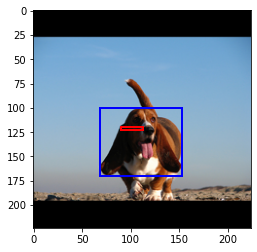

Category6.7235206e-08
TestPseudo12
23


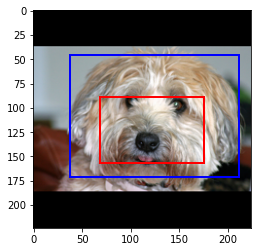

Category1.6947689e-07
TestPseudo12
15


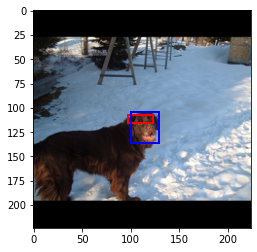

Category8.077779e-08
TestPseudo12
7


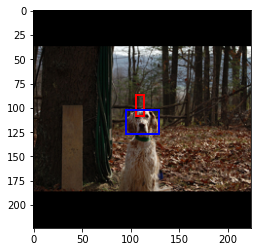

Category9.456335e-08
TestPseudo12
5


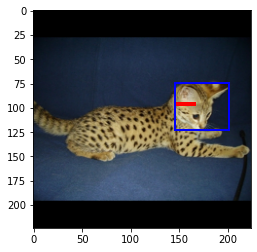

Category5.745677e-07
TestPseudo12
23


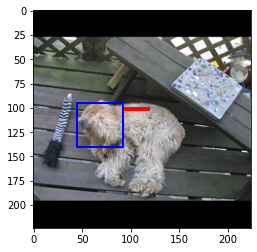

Category3.95487e-08
TestPseudo12
3


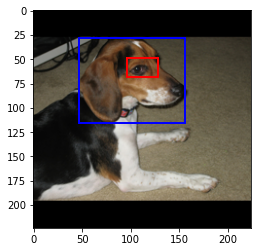

Category1.1763634e-06
TestPseudo13
12


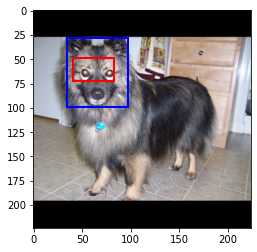

Category5.8340788e-08
TestPseudo12
4


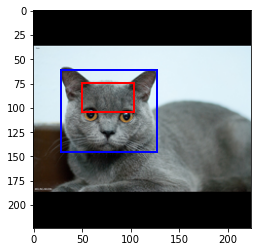

Category1.0454256e-07
TestPseudo12
8


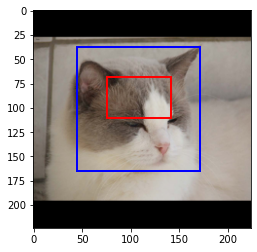

Category1.6322142e-07
TestPseudo12
3


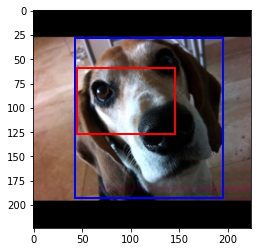

Category6.69021e-07
TestPseudo12
23


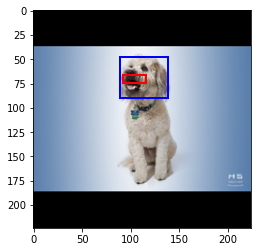

Category2.3406399e-07
TestPseudo12
4


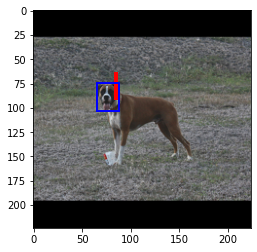

Category3.2451672e-07
TestPseudo12
21


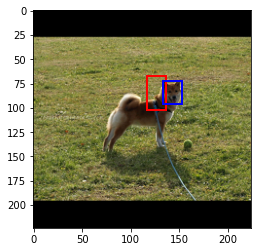

Category2.2548457e-08
TestPseudo12
4


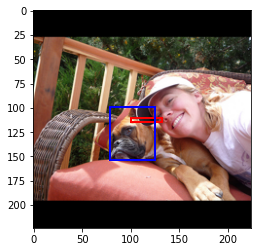

Category3.6888828e-08
TestPseudo12
6


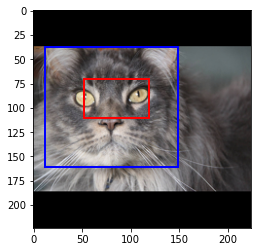

Category5.360528e-07
TestPseudo12
1


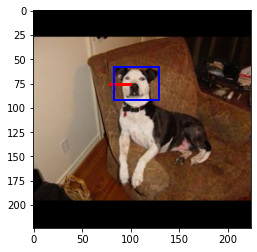

Category4.7835762e-08
TestPseudo12
9


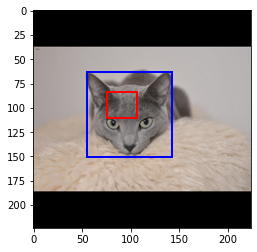

Category2.4210806e-07
TestPseudo12
5


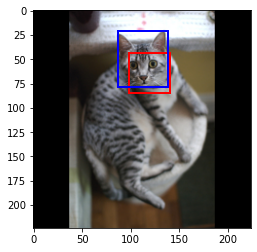

In [118]:
# Fetching the non mobile-net processed images so we can actually see them
for _ in range(20):
    i = np.random.randint(len(processed_data))
    img, class_id, true_bounding_box = processed_data[i]

    pred = model.predict(np.array([preprocess_input(img)]))
    
    speciesratio = pred[0][0][0] #Lazy start vector
    
   # print(pred[0][0][0])
    
    x = 0
    for category in pred[0][0]:
        x += 1
        if category > speciesratio:
            #print(category)
            y=x
            speciesratio = category
        

        #speciesratio = pred[0][0][0]

    print("Category"+str(category))
    print("TestPseudo"+str(y))
    #  if pred[0][0][0] < .5:
    #      print("Called it a Cat")
    #  else:
    #      print("Called it a dog")

    print(species)

    # Thre true box is in blue, predicted in red
    plot_with_box(img, BoundingBox(*pred[1][0]), true_bounding_box)
    

### Part 3: Import and prepare a CNN

Like in previous labs and exercises, we're applying transfer learning. Import a pre-trained network from Keras with `include_top=False`. Then, using the Keras functional API, give that network two prediction heads: one for classification and one for object localization.

You'll have to decide which loss functions to use, and how to weight the predictions from each head during training at this point as well. In the notebook we used `binary_crossentropy` for the classifier, and `mse` for the localizer with weights of `1` and `800` respectively (those weights were chosen arbitrarily, but worked decently). You may wish to experiment with other options.

**Challenge Opportunity** in the provided notebook, we only classify images as being of a "dog" or "cat" but the provided dataset has more detailed labels for the breed of each dog or cat. You can choose to implement a simpler "dog or cat" classifier, as done in the provided notebook, or make your network predict the breed. If you go for breed then your classification head will need a node for each possible breed, which means you will also not want to use `binary_crossentropy` as your loss function, since it is designed for binary classifiers.

**Challenge Opportunity** in the provided notebook we have our network predict the pixel position of the bounding box. Better performance can often be achieved by normalizing these values between 0-1. In other words, for each of the four points in our bounding box, have your model predict those positions as a scalar relative to the image size, rather than absolute pixel position. Normalizing these outputs will require you to change the way we process the image and XML input data.

**Challenge Opportunity** Accuracy is one popular metric for judging the performance of a classifier. [Intersection over Union](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) is a popular metric for judging the accuracy of an object localization model. Consider implementing a custom metric to compute the intersection over union as a validation metric for your model, and plot its change over time during training alongside accuracy and the `mse` loss.

In [57]:
# for the sake of training speed, we're going to import one of the smallest built in models. 
# it still has a LOT of complexity, and over 3 million parameters
import numpy as np
import matplotlib.pyplot as plt

# must disable it. 
from tensorflow import compat
compat.v1.disable_eager_execution()

# NOTE: preprocess_input is VERY IMPORTANT. Each net has diferent expectations and using
# plain raw image data, not preprocessed, will utterly fail!
from tensorflow.keras.applications.xception import (Xception, 
                                        preprocess_input as xception_preprocess_input, 
                                        decode_predictions as xception_decode_predictions)

from tensorflow.keras.applications.mobilenet_v2 import (MobileNetV2, 
                                            preprocess_input as mobile_preprocess_input, 
                                            decode_predictions as mobile_decode_predictions)

from tensorflow.keras.applications.resnet50 import (ResNet50, 
                                        preprocess_input as resnet_preprocess_input, 
                                        decode_predictions as resnet_decode_predictions)


# We'll look at these three prebuilt models and see how/if they differ on a few samples
name_model_shape_preprocess_decode_list = [
    ('Xception', Xception(weights="imagenet", include_top =False), (299, 299), xception_preprocess_input, xception_decode_predictions),
    ('MobileNetV2', MobileNetV2(weights="imagenet", include_top =False), (224, 224), mobile_preprocess_input, mobile_decode_predictions),
    ('ResNet50', ResNet50(weights="imagenet", include_top =False), (224, 224), resnet_preprocess_input, resnet_decode_predictions),
]

 
 

c:\users\sentinal\.virtualenvs\intro-to-deep-learning-san2vixs\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


94773248/94765736 [==============================] - 41s 0us/step


In [58]:
# Get some human readable output...
image_classifications_map = {0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'
}

In [59]:
import os
from tensorflow.keras.preprocessing import image as keras_image

photo_location = PATH_TO_IMAGES


for name in os.listdir(photo_location):
    print(name)
    if name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    image = keras_image.load_img(photo_location + name)
    #plt.imshow(image)
    #plt.show()

Abyssinian_1.jpg
Abyssinian_10.jpg
Abyssinian_100.jpg
Abyssinian_101.jpg
Abyssinian_102.jpg
Abyssinian_103.jpg
Abyssinian_104.jpg
Abyssinian_105.jpg
Abyssinian_106.jpg
Abyssinian_107.jpg
Abyssinian_108.jpg
Abyssinian_109.jpg
Abyssinian_11.jpg
Abyssinian_110.jpg
Abyssinian_111.jpg
Abyssinian_112.jpg
Abyssinian_113.jpg
Abyssinian_114.jpg
Abyssinian_115.jpg
Abyssinian_116.jpg
Abyssinian_117.jpg
Abyssinian_118.jpg
Abyssinian_119.jpg
Abyssinian_12.jpg
Abyssinian_120.jpg
Abyssinian_121.jpg
Abyssinian_122.jpg
Abyssinian_123.jpg
Abyssinian_124.jpg
Abyssinian_125.jpg
Abyssinian_126.jpg
Abyssinian_127.jpg
Abyssinian_128.jpg
Abyssinian_129.jpg
Abyssinian_13.jpg
Abyssinian_130.jpg
Abyssinian_131.jpg
Abyssinian_132.jpg
Abyssinian_133.jpg
Abyssinian_134.jpg
Abyssinian_135.jpg
Abyssinian_136.jpg
Abyssinian_137.jpg
Abyssinian_138.jpg
Abyssinian_139.jpg
Abyssinian_14.jpg
Abyssinian_140.jpg
Abyssinian_141.jpg
Abyssinian_142.jpg
Abyssinian_143.jpg
Abyssinian_144.jpg
Abyssinian_145.jpg
Abyssinian_146.jpg


american_bulldog_83.jpg
american_bulldog_84.jpg
american_bulldog_85.jpg
american_bulldog_86.jpg
american_bulldog_87.jpg
american_bulldog_89.jpg
american_bulldog_9.jpg
american_bulldog_90.jpg
american_bulldog_91.jpg
american_bulldog_92.jpg
american_bulldog_93.jpg
american_bulldog_94.jpg
american_bulldog_95.jpg
american_bulldog_96.jpg
american_bulldog_97.jpg
american_bulldog_98.jpg
american_bulldog_99.jpg
american_pit_bull_terrier_1.jpg
american_pit_bull_terrier_10.jpg
american_pit_bull_terrier_100.jpg
american_pit_bull_terrier_101.jpg
american_pit_bull_terrier_102.jpg
american_pit_bull_terrier_103.jpg
american_pit_bull_terrier_104.jpg
american_pit_bull_terrier_105.jpg
american_pit_bull_terrier_106.jpg
american_pit_bull_terrier_107.jpg
american_pit_bull_terrier_108.jpg
american_pit_bull_terrier_109.jpg
american_pit_bull_terrier_11.jpg
american_pit_bull_terrier_110.jpg
american_pit_bull_terrier_111.jpg
american_pit_bull_terrier_112.jpg
american_pit_bull_terrier_113.jpg
american_pit_bull_t

basset_hound_148.jpg
basset_hound_149.jpg
basset_hound_15.jpg
basset_hound_150.jpg
basset_hound_151.jpg
basset_hound_152.jpg
basset_hound_153.jpg
basset_hound_154.jpg
basset_hound_155.jpg
basset_hound_156.jpg
basset_hound_157.jpg
basset_hound_158.jpg
basset_hound_159.jpg
basset_hound_16.jpg
basset_hound_160.jpg
basset_hound_161.jpg
basset_hound_162.jpg
basset_hound_163.jpg
basset_hound_164.jpg
basset_hound_165.jpg
basset_hound_166.jpg
basset_hound_167.jpg
basset_hound_168.jpg
basset_hound_169.jpg
basset_hound_17.jpg
basset_hound_170.jpg
basset_hound_171.jpg
basset_hound_172.jpg
basset_hound_173.jpg
basset_hound_174.jpg
basset_hound_175.jpg
basset_hound_176.jpg
basset_hound_177.jpg
basset_hound_178.jpg
basset_hound_179.jpg
basset_hound_18.jpg
basset_hound_180.jpg
basset_hound_181.jpg
basset_hound_182.jpg
basset_hound_183.jpg
basset_hound_184.jpg
basset_hound_185.jpg
basset_hound_186.jpg
basset_hound_187.jpg
basset_hound_188.jpg
basset_hound_189.jpg
basset_hound_19.jpg
basset_hound_190.j

Bengal_66.jpg
Bengal_67.jpg
Bengal_68.jpg
Bengal_69.jpg
Bengal_7.jpg
Bengal_70.jpg
Bengal_71.jpg
Bengal_72.jpg
Bengal_73.jpg
Bengal_74.jpg
Bengal_75.jpg
Bengal_76.jpg
Bengal_77.jpg
Bengal_78.jpg
Bengal_79.jpg
Bengal_8.jpg
Bengal_80.jpg
Bengal_81.jpg
Bengal_82.jpg
Bengal_83.jpg
Bengal_84.jpg
Bengal_85.jpg
Bengal_86.jpg
Bengal_87.jpg
Bengal_88.jpg
Bengal_89.jpg
Bengal_9.jpg
Bengal_90.jpg
Bengal_91.jpg
Bengal_92.jpg
Bengal_93.jpg
Bengal_94.jpg
Bengal_95.jpg
Bengal_96.jpg
Bengal_97.jpg
Bengal_98.jpg
Bengal_99.jpg
Birman_1.jpg
Birman_10.jpg
Birman_100.jpg
Birman_101.jpg
Birman_102.jpg
Birman_103.jpg
Birman_104.jpg
Birman_105.jpg
Birman_106.jpg
Birman_107.jpg
Birman_108.jpg
Birman_109.jpg
Birman_11.jpg
Birman_110.jpg
Birman_111.jpg
Birman_112.jpg
Birman_113.jpg
Birman_114.jpg
Birman_115.jpg
Birman_116.jpg
Birman_117.jpg
Birman_118.jpg
Birman_119.jpg
Birman_12.jpg
Birman_120.jpg
Birman_121.jpg
Birman_122.jpg
Birman_123.jpg
Birman_124.jpg
Birman_125.jpg
Birman_126.jpg
Birman_127.jpg
Birman_128

boxer_43.jpg
boxer_44.jpg
boxer_45.jpg
boxer_46.jpg
boxer_47.jpg
boxer_48.jpg
boxer_49.jpg
boxer_5.jpg
boxer_50.jpg
boxer_51.jpg
boxer_52.jpg
boxer_53.jpg
boxer_54.jpg
boxer_55.jpg
boxer_56.jpg
boxer_57.jpg
boxer_58.jpg
boxer_59.jpg
boxer_6.jpg
boxer_60.jpg
boxer_61.jpg
boxer_62.jpg
boxer_63.jpg
boxer_64.jpg
boxer_65.jpg
boxer_66.jpg
boxer_67.jpg
boxer_68.jpg
boxer_69.jpg
boxer_7.jpg
boxer_70.jpg
boxer_71.jpg
boxer_72.jpg
boxer_73.jpg
boxer_74.jpg
boxer_75.jpg
boxer_76.jpg
boxer_77.jpg
boxer_78.jpg
boxer_79.jpg
boxer_8.jpg
boxer_80.jpg
boxer_81.jpg
boxer_82.jpg
boxer_83.jpg
boxer_84.jpg
boxer_85.jpg
boxer_86.jpg
boxer_87.jpg
boxer_88.jpg
boxer_89.jpg
boxer_9.jpg
boxer_90.jpg
boxer_91.jpg
boxer_92.jpg
boxer_93.jpg
boxer_94.jpg
boxer_95.jpg
boxer_96.jpg
boxer_97.jpg
boxer_98.jpg
boxer_99.jpg
British_Shorthair_10.jpg
British_Shorthair_100.jpg
British_Shorthair_101.jpg
British_Shorthair_102.jpg
British_Shorthair_103.jpg
British_Shorthair_104.jpg
British_Shorthair_105.jpg
British_Shorthair_

english_cocker_spaniel_185.jpg
english_cocker_spaniel_186.jpg
english_cocker_spaniel_187.jpg
english_cocker_spaniel_188.jpg
english_cocker_spaniel_189.jpg
english_cocker_spaniel_19.jpg
english_cocker_spaniel_190.jpg
english_cocker_spaniel_191.jpg
english_cocker_spaniel_192.jpg
english_cocker_spaniel_193.jpg
english_cocker_spaniel_194.jpg
english_cocker_spaniel_195.jpg
english_cocker_spaniel_196.jpg
english_cocker_spaniel_197.jpg
english_cocker_spaniel_198.jpg
english_cocker_spaniel_199.jpg
english_cocker_spaniel_2.jpg
english_cocker_spaniel_20.jpg
english_cocker_spaniel_200.jpg
english_cocker_spaniel_21.jpg
english_cocker_spaniel_22.jpg
english_cocker_spaniel_23.jpg
english_cocker_spaniel_24.jpg
english_cocker_spaniel_25.jpg
english_cocker_spaniel_26.jpg
english_cocker_spaniel_27.jpg
english_cocker_spaniel_28.jpg
english_cocker_spaniel_29.jpg
english_cocker_spaniel_3.jpg
english_cocker_spaniel_30.jpg
english_cocker_spaniel_31.jpg
english_cocker_spaniel_32.jpg
english_cocker_spaniel_33.

german_shorthaired_119.jpg
german_shorthaired_12.jpg
german_shorthaired_120.jpg
german_shorthaired_121.jpg
german_shorthaired_122.jpg
german_shorthaired_123.jpg
german_shorthaired_124.jpg
german_shorthaired_125.jpg
german_shorthaired_126.jpg
german_shorthaired_127.jpg
german_shorthaired_128.jpg
german_shorthaired_129.jpg
german_shorthaired_13.jpg
german_shorthaired_130.jpg
german_shorthaired_131.jpg
german_shorthaired_132.jpg
german_shorthaired_133.jpg
german_shorthaired_134.jpg
german_shorthaired_135.jpg
german_shorthaired_136.jpg
german_shorthaired_137.jpg
german_shorthaired_138.jpg
german_shorthaired_139.jpg
german_shorthaired_14.jpg
german_shorthaired_140.jpg
german_shorthaired_141.jpg
german_shorthaired_142.jpg
german_shorthaired_143.jpg
german_shorthaired_144.jpg
german_shorthaired_145.jpg
german_shorthaired_146.jpg
german_shorthaired_147.jpg
german_shorthaired_148.jpg
german_shorthaired_149.jpg
german_shorthaired_15.jpg
german_shorthaired_150.jpg
german_shorthaired_151.jpg
germa

great_pyrenees_60.jpg
great_pyrenees_61.jpg
great_pyrenees_62.jpg
great_pyrenees_63.jpg
great_pyrenees_64.jpg
great_pyrenees_65.jpg
great_pyrenees_66.jpg
great_pyrenees_67.jpg
great_pyrenees_68.jpg
great_pyrenees_69.jpg
great_pyrenees_7.jpg
great_pyrenees_70.jpg
great_pyrenees_71.jpg
great_pyrenees_72.jpg
great_pyrenees_73.jpg
great_pyrenees_74.jpg
great_pyrenees_75.jpg
great_pyrenees_76.jpg
great_pyrenees_77.jpg
great_pyrenees_78.jpg
great_pyrenees_79.jpg
great_pyrenees_8.jpg
great_pyrenees_80.jpg
great_pyrenees_81.jpg
great_pyrenees_82.jpg
great_pyrenees_83.jpg
great_pyrenees_84.jpg
great_pyrenees_85.jpg
great_pyrenees_86.jpg
great_pyrenees_87.jpg
great_pyrenees_88.jpg
great_pyrenees_89.jpg
great_pyrenees_9.jpg
great_pyrenees_90.jpg
great_pyrenees_91.jpg
great_pyrenees_92.jpg
great_pyrenees_93.jpg
great_pyrenees_94.jpg
great_pyrenees_95.jpg
great_pyrenees_96.jpg
great_pyrenees_97.jpg
great_pyrenees_98.jpg
great_pyrenees_99.jpg
havanese_1.jpg
havanese_10.jpg
havanese_100.jpg
havanese_

Maine_Coon_150.jpg
Maine_Coon_151.jpg
Maine_Coon_152.jpg
Maine_Coon_153.jpg
Maine_Coon_154.jpg
Maine_Coon_155.jpg
Maine_Coon_157.jpg
Maine_Coon_158.jpg
Maine_Coon_159.jpg
Maine_Coon_16.jpg
Maine_Coon_160.jpg
Maine_Coon_161.jpg
Maine_Coon_162.jpg
Maine_Coon_163.jpg
Maine_Coon_164.jpg
Maine_Coon_167.jpg
Maine_Coon_168.jpg
Maine_Coon_169.jpg
Maine_Coon_17.jpg
Maine_Coon_170.jpg
Maine_Coon_171.jpg
Maine_Coon_173.jpg
Maine_Coon_174.jpg
Maine_Coon_175.jpg
Maine_Coon_176.jpg
Maine_Coon_18.jpg
Maine_Coon_180.jpg
Maine_Coon_182.jpg
Maine_Coon_184.jpg
Maine_Coon_186.jpg
Maine_Coon_187.jpg
Maine_Coon_189.jpg
Maine_Coon_19.jpg
Maine_Coon_191.jpg
Maine_Coon_192.jpg
Maine_Coon_193.jpg
Maine_Coon_194.jpg
Maine_Coon_195.jpg
Maine_Coon_196.jpg
Maine_Coon_197.jpg
Maine_Coon_2.jpg
Maine_Coon_201.jpg
Maine_Coon_203.jpg
Maine_Coon_204.jpg
Maine_Coon_205.jpg
Maine_Coon_206.jpg
Maine_Coon_207.jpg
Maine_Coon_208.jpg
Maine_Coon_21.jpg
Maine_Coon_210.jpg
Maine_Coon_211.jpg
Maine_Coon_213.jpg
Maine_Coon_214.jpg


newfoundland_105.jpg
newfoundland_106.jpg
newfoundland_107.jpg
newfoundland_108.jpg
newfoundland_109.jpg
newfoundland_11.jpg
newfoundland_110.jpg
newfoundland_111.jpg
newfoundland_112.jpg
newfoundland_113.jpg
newfoundland_114.jpg
newfoundland_115.jpg
newfoundland_116.jpg
newfoundland_117.jpg
newfoundland_118.jpg
newfoundland_119.jpg
newfoundland_12.jpg
newfoundland_120.jpg
newfoundland_121.jpg
newfoundland_122.jpg
newfoundland_123.jpg
newfoundland_124.jpg
newfoundland_125.jpg
newfoundland_126.jpg
newfoundland_127.jpg
newfoundland_128.jpg
newfoundland_129.jpg
newfoundland_13.jpg
newfoundland_130.jpg
newfoundland_131.jpg
newfoundland_132.jpg
newfoundland_133.jpg
newfoundland_134.jpg
newfoundland_135.jpg
newfoundland_136.jpg
newfoundland_137.jpg
newfoundland_138.jpg
newfoundland_139.jpg
newfoundland_14.jpg
newfoundland_140.jpg
newfoundland_141.jpg
newfoundland_142.jpg
newfoundland_143.jpg
newfoundland_144.jpg
newfoundland_145.jpg
newfoundland_146.jpg
newfoundland_147.jpg
newfoundland_148.

pomeranian_162.jpg
pomeranian_163.jpg
pomeranian_164.jpg
pomeranian_165.jpg
pomeranian_166.jpg
pomeranian_167.jpg
pomeranian_168.jpg
pomeranian_169.jpg
pomeranian_17.jpg
pomeranian_170.jpg
pomeranian_171.jpg
pomeranian_172.jpg
pomeranian_173.jpg
pomeranian_174.jpg
pomeranian_175.jpg
pomeranian_176.jpg
pomeranian_177.jpg
pomeranian_178.jpg
pomeranian_179.jpg
pomeranian_18.jpg
pomeranian_180.jpg
pomeranian_181.jpg
pomeranian_182.jpg
pomeranian_183.jpg
pomeranian_184.jpg
pomeranian_185.jpg
pomeranian_186.jpg
pomeranian_187.jpg
pomeranian_188.jpg
pomeranian_189.jpg
pomeranian_19.jpg
pomeranian_190.jpg
pomeranian_191.jpg
pomeranian_192.jpg
pomeranian_193.jpg
pomeranian_194.jpg
pomeranian_195.jpg
pomeranian_196.jpg
pomeranian_197.jpg
pomeranian_198.jpg
pomeranian_199.jpg
pomeranian_2.jpg
pomeranian_20.jpg
pomeranian_200.jpg
pomeranian_21.jpg
pomeranian_22.jpg
pomeranian_23.jpg
pomeranian_24.jpg
pomeranian_25.jpg
pomeranian_26.jpg
pomeranian_27.jpg
pomeranian_28.jpg
pomeranian_29.jpg
pomerani

Russian_Blue_120.jpg
Russian_Blue_122.jpg
Russian_Blue_123.jpg
Russian_Blue_124.jpg
Russian_Blue_125.jpg
Russian_Blue_127.jpg
Russian_Blue_128.jpg
Russian_Blue_129.jpg
Russian_Blue_13.jpg
Russian_Blue_130.jpg
Russian_Blue_131.jpg
Russian_Blue_132.jpg
Russian_Blue_133.jpg
Russian_Blue_135.jpg
Russian_Blue_136.jpg
Russian_Blue_137.jpg
Russian_Blue_139.jpg
Russian_Blue_14.jpg
Russian_Blue_140.jpg
Russian_Blue_142.jpg
Russian_Blue_143.jpg
Russian_Blue_144.jpg
Russian_Blue_145.jpg
Russian_Blue_146.jpg
Russian_Blue_147.jpg
Russian_Blue_148.jpg
Russian_Blue_149.jpg
Russian_Blue_150.jpg
Russian_Blue_151.jpg
Russian_Blue_152.jpg
Russian_Blue_153.jpg
Russian_Blue_154.jpg
Russian_Blue_155.jpg
Russian_Blue_156.jpg
Russian_Blue_157.jpg
Russian_Blue_158.jpg
Russian_Blue_159.jpg
Russian_Blue_16.jpg
Russian_Blue_160.jpg
Russian_Blue_161.jpg
Russian_Blue_162.jpg
Russian_Blue_164.jpg
Russian_Blue_165.jpg
Russian_Blue_166.jpg
Russian_Blue_168.jpg
Russian_Blue_169.jpg
Russian_Blue_17.jpg
Russian_Blue_170.

samoyed_115.jpg
samoyed_116.jpg
samoyed_117.jpg
samoyed_118.jpg
samoyed_119.jpg
samoyed_12.jpg
samoyed_120.jpg
samoyed_121.jpg
samoyed_122.jpg
samoyed_123.jpg
samoyed_124.jpg
samoyed_125.jpg
samoyed_126.jpg
samoyed_127.jpg
samoyed_128.jpg
samoyed_129.jpg
samoyed_13.jpg
samoyed_130.jpg
samoyed_131.jpg
samoyed_132.jpg
samoyed_133.jpg
samoyed_134.jpg
samoyed_135.jpg
samoyed_136.jpg
samoyed_137.jpg
samoyed_138.jpg
samoyed_139.jpg
samoyed_14.jpg
samoyed_140.jpg
samoyed_141.jpg
samoyed_142.jpg
samoyed_143.jpg
samoyed_144.jpg
samoyed_145.jpg
samoyed_146.jpg
samoyed_147.jpg
samoyed_148.jpg
samoyed_149.jpg
samoyed_15.jpg
samoyed_150.jpg
samoyed_151.jpg
samoyed_152.jpg
samoyed_153.jpg
samoyed_154.jpg
samoyed_155.jpg
samoyed_156.jpg
samoyed_157.jpg
samoyed_158.jpg
samoyed_159.jpg
samoyed_16.jpg
samoyed_160.jpg
samoyed_161.jpg
samoyed_162.jpg
samoyed_163.jpg
samoyed_164.jpg
samoyed_165.jpg
samoyed_166.jpg
samoyed_167.jpg
samoyed_168.jpg
samoyed_169.jpg
samoyed_17.jpg
samoyed_170.jpg
samoyed_171.jp

shiba_inu_129.jpg
shiba_inu_13.jpg
shiba_inu_130.jpg
shiba_inu_131.jpg
shiba_inu_132.jpg
shiba_inu_133.jpg
shiba_inu_134.jpg
shiba_inu_135.jpg
shiba_inu_136.jpg
shiba_inu_137.jpg
shiba_inu_139.jpg
shiba_inu_14.jpg
shiba_inu_140.jpg
shiba_inu_141.jpg
shiba_inu_142.jpg
shiba_inu_143.jpg
shiba_inu_144.jpg
shiba_inu_145.jpg
shiba_inu_146.jpg
shiba_inu_147.jpg
shiba_inu_15.jpg
shiba_inu_150.jpg
shiba_inu_152.jpg
shiba_inu_153.jpg
shiba_inu_154.jpg
shiba_inu_155.jpg
shiba_inu_156.jpg
shiba_inu_157.jpg
shiba_inu_158.jpg
shiba_inu_159.jpg
shiba_inu_16.jpg
shiba_inu_160.jpg
shiba_inu_161.jpg
shiba_inu_162.jpg
shiba_inu_163.jpg
shiba_inu_164.jpg
shiba_inu_165.jpg
shiba_inu_166.jpg
shiba_inu_168.jpg
shiba_inu_170.jpg
shiba_inu_171.jpg
shiba_inu_172.jpg
shiba_inu_173.jpg
shiba_inu_174.jpg
shiba_inu_175.jpg
shiba_inu_176.jpg
shiba_inu_177.jpg
shiba_inu_178.jpg
shiba_inu_179.jpg
shiba_inu_18.jpg
shiba_inu_180.jpg
shiba_inu_181.jpg
shiba_inu_182.jpg
shiba_inu_183.jpg
shiba_inu_185.jpg
shiba_inu_186.j

Sphynx_43.jpg
Sphynx_44.jpg
Sphynx_45.jpg
Sphynx_46.jpg
Sphynx_47.jpg
Sphynx_48.jpg
Sphynx_49.jpg
Sphynx_5.jpg
Sphynx_51.jpg
Sphynx_53.jpg
Sphynx_54.jpg
Sphynx_55.jpg
Sphynx_56.jpg
Sphynx_57.jpg
Sphynx_58.jpg
Sphynx_59.jpg
Sphynx_61.jpg
Sphynx_65.jpg
Sphynx_66.jpg
Sphynx_67.jpg
Sphynx_70.jpg
Sphynx_71.jpg
Sphynx_72.jpg
Sphynx_73.jpg
Sphynx_74.jpg
Sphynx_75.jpg
Sphynx_76.jpg
Sphynx_77.jpg
Sphynx_78.jpg
Sphynx_8.jpg
Sphynx_80.jpg
Sphynx_82.jpg
Sphynx_83.jpg
Sphynx_84.jpg
Sphynx_85.jpg
Sphynx_87.jpg
Sphynx_88.jpg
Sphynx_89.jpg
Sphynx_9.jpg
Sphynx_90.jpg
Sphynx_91.jpg
Sphynx_92.jpg
Sphynx_93.jpg
Sphynx_94.jpg
Sphynx_95.jpg
Sphynx_96.jpg
Sphynx_98.jpg
Sphynx_99.jpg
staffordshire_bull_terrier_1.jpg
staffordshire_bull_terrier_10.jpg
staffordshire_bull_terrier_100.jpg
staffordshire_bull_terrier_101.jpg
staffordshire_bull_terrier_102.jpg
staffordshire_bull_terrier_103.jpg
staffordshire_bull_terrier_104.jpg
staffordshire_bull_terrier_105.jpg
staffordshire_bull_terrier_106.jpg
staffordshire_bull_

wheaten_terrier_14.jpg
wheaten_terrier_140.jpg
wheaten_terrier_141.jpg
wheaten_terrier_142.jpg
wheaten_terrier_143.jpg
wheaten_terrier_144.jpg
wheaten_terrier_145.jpg
wheaten_terrier_146.jpg
wheaten_terrier_147.jpg
wheaten_terrier_148.jpg
wheaten_terrier_149.jpg
wheaten_terrier_15.jpg
wheaten_terrier_150.jpg
wheaten_terrier_151.jpg
wheaten_terrier_152.jpg
wheaten_terrier_153.jpg
wheaten_terrier_154.jpg
wheaten_terrier_155.jpg
wheaten_terrier_156.jpg
wheaten_terrier_157.jpg
wheaten_terrier_158.jpg
wheaten_terrier_159.jpg
wheaten_terrier_16.jpg
wheaten_terrier_160.jpg
wheaten_terrier_161.jpg
wheaten_terrier_162.jpg
wheaten_terrier_163.jpg
wheaten_terrier_164.jpg
wheaten_terrier_165.jpg
wheaten_terrier_166.jpg
wheaten_terrier_167.jpg
wheaten_terrier_168.jpg
wheaten_terrier_169.jpg
wheaten_terrier_17.jpg
wheaten_terrier_170.jpg
wheaten_terrier_171.jpg
wheaten_terrier_172.jpg
wheaten_terrier_173.jpg
wheaten_terrier_174.jpg
wheaten_terrier_175.jpg
wheaten_terrier_176.jpg
wheaten_terrier_177.

yorkshire_terrier_83.jpg
yorkshire_terrier_84.jpg
yorkshire_terrier_85.jpg
yorkshire_terrier_86.jpg
yorkshire_terrier_87.jpg
yorkshire_terrier_88.jpg
yorkshire_terrier_89.jpg
yorkshire_terrier_9.jpg
yorkshire_terrier_90.jpg
yorkshire_terrier_91.jpg
yorkshire_terrier_92.jpg
yorkshire_terrier_93.jpg
yorkshire_terrier_94.jpg
yorkshire_terrier_95.jpg
yorkshire_terrier_96.jpg
yorkshire_terrier_97.jpg
yorkshire_terrier_98.jpg
yorkshire_terrier_99.jpg


In [64]:
# We have to process each image to fit our networks expected input size... this can be a bit of a hassle.
# Keras provides an okay library function for doing this, but it squashes images rather than padding them.
# So this code pads the image to be square, then we can safely rely on Keras to shink the image without
# squashing the aspect ratio
from PIL import Image, ImageOps

resized_location = './resized2/' 

for name in os.listdir(photo_location):
    if name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    image = Image.open(photo_location + name)
    
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    
    width, height = image.size
    
 
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    
    # Save for display as well as to use Keras preprocessing later
    image.save(resized_location + name)

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
__________________________________________________________________________________________________


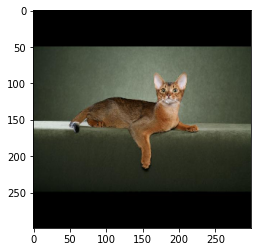

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 10, 10, 2048)

In [79]:
 #Now we've got 3 images in the right shape, we have to format them to be "neural network friedly"
# Which means turning the RGB image into a 3D tensor
# Lucky for us, Keras does the heavy lifting here
for image_name in os.listdir(resized_location):
    if image_name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
        
    # We want to do this for each of our 3 models
    first_time = True
     
    image = keras_image.load_img(resized_location + image_name, target_size=desired_shape)
    
    model.summary()

    # Even though the images are slightly different sizes, don't plot them several times
    if first_time:
        plt.imshow(image)
        plt.show()
        first_time = False


    # Awkward because our model is trained in batches, we have to be explicit that 
    # we're providing one example.
    array = keras_image.img_to_array(image)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    label = model.predict(array)

    #print(label)

    pretty_labels =  decode_predictions(label, model)

    print(f'=============\n{pretty_labels}\n')

In [80]:
# One really cool thing you can do with convolutional neural nets is visualize the activation maps
# which can give insight into what the convolutional kernels might be doing, and especially 
# about which areas of the image the CNN is focused on.
import cv2
import matplotlib.image as mpimg
from tensorflow.keras import backend as K


def cam(image_path, model, desired_shape, preprocess_input, decode_predictions, final_conv_name, ax):
    # This should look familiar from the above.
    # We're just loading the image and getting our networks prediction 
    image = keras_image.load_img(image_path, target_size=desired_shape)
    input_data = keras_image.img_to_array(image)
    input_data = np.expand_dims(input_data, axis=0)
    input_data = preprocess_input(input_data)
    
    # Use the model to make a prediction so we can label the image later.
    preds = model.predict(input_data)
    predictions = decode_predictions(preds, top=3)
    
    # We also get the output values for the final layer related to the top prediction. 
    top_prediction = np.argmax(preds[0])
    output = model.output[:, top_prediction]
    
    # We have to fetch the results of the final convolutional layer
    # Because the graidents of that layer will tell us which pixels
    # Contributed most to our models decision
    last_conv_layer = model.get_layer(final_conv_name)

    # And now we want to get the mean gradient intensity of 
    # all the filters in that layer. We use 'output' here to 
    # compute the gradient for the output associated with the 
    # top prediction. 
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # This essentially creates a function that acts as a model, but where
    # it's easier to get the values out that we want. 
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([input_data])
    
    # Using the avg gradient and the last conv layer's output
    # calculate the weight of each pixel's contribution. 
    for i, pooled_gradient_value in enumerate(pooled_grads_value):
        conv_layer_output_value[:, :, i] *= pooled_gradient_value
    
    # Build the heatmap
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Load the image with openCV
    img = cv2.imread(image_path)

    # Resize the heatmap, since the final conv layer isn't the same size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Move to RGB values as ints 0-255 instead of floats 0-1
    heatmap = np.uint8(255 * heatmap)
    
    # Build the heatmap numerically
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    
    # Save it, hilariously, so that we can show it with matplotlib
    output = 'heatmaps/output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img = mpimg.imread(output)

    # Show it.
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(predictions[0][0][1])    


In [ ]:
final_layer_names = [
    'block14_sepconv2',
    'Conv_1',
    'conv5_block3_3_conv'
]
'    ('Xception', 
Xception(weights="imagenet", include_top =False), 
(299, 299), 
xception_preprocess_input, 
xception_decode_predictions),
'

for image_name in os.listdir(resized_location):
    if image_name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for i, (name, model, shape, preprocess, decode) in enumerate(name_model_shape_preprocess_decode_list):
        ax = axs[i]
        final_layer_name = final_layer_names[i]
        cam(resized_location + image_name,model, shape, preprocess, decode, final_layer_name, ax)
    plt.show()